In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def interpolate_PSA(num):
    diff = [-300,-200,-100,-50,0,50,100,200,300]
    PSAs = [1164,998,621,371,185,145,117,90,83]
    from scipy.interpolate import interp1d
    cs = interp1d(diff, PSAs)
    num = 10000 * num
    num[num > 300] = 300
    num[num < -300] = -300
    itpl = interp1d(diff, PSAs)
    return itpl(num)

def get_SMM(PSA_data):
    A = PSA_data[:,:30]
    B = PSA_data[:,30:]
    CPR_A = A / 100 * np.linspace(1,30,30) * 0.002
    CPR_B = B / 100 * 0.06
    CPR = np.hstack((CPR_A , CPR_B))
    SMM = 1 - (1 - CPR) ** (1 / 12)
    return SMM

In [3]:
paths = np.array(pd.read_excel('HW5_data.xlsx')) * 0.01
N_paths = 500

def generate_cashflow(shock=0):

    DF = np.cumprod((1+ (paths+shock)/12), axis=1)
    DF = 1 / DF

    denominator = np.ones((500,360))

    for i in range(241):
        sub = DF[:,i:i+120]
        denominator[:,i] = np.sum(sub,axis=1)

    nominator = np.zeros((500,360))
    nominator[:,:241] = (1 - DF[:,119:]) * 12
    swap_rates = nominator / denominator
    swap_rates[:,241:] = swap_rates[:,240].reshape(-1,1)

    swap_rates = swap_rates[:N_paths,:]
    
    mortgage_rate = swap_rates + 0.0175
    WAC = 0.0407
    Curr_amt = 405903
    M = 331
    mthly_pymt = WAC/12 * (1 + WAC/12) ** M / ((1 + WAC/12) ** M - 1) * Curr_amt
    
    difference = mortgage_rate - WAC
    PSAs = interpolate_PSA(difference)
    SMM = get_SMM(PSAs)
    cash_flow_store = []
   
    for i in range(N_paths):
        principal_end = [Curr_amt]
        cash_flow = []
        j = 0
        while principal_end[-1] > 0.1:
            smm = SMM[i,j]
            pymt = mthly_pymt + principal_end[-1] * smm
            cash_flow.append(pymt)
            interest = principal_end[-1] * WAC / 12
            principal_pymt = pymt - interest
            if principal_end[-1] - principal_pymt > 0:
                principal_end.append(principal_end[-1] - principal_pymt)
            else:
                principal_end.append(0)
            j += 1
        cash_flow_store.append(cash_flow)    
    return cash_flow_store

In [4]:
def solve_oas(oas, price, cur_balance, cash_flow_store, discount):
    PVs = []
    for i in range(N_paths):
        temp = 0
        d = np.cumprod(1 + (discount[i]+oas)/12)
        cash_flow = cash_flow_store[i]
        for j in range(len(cash_flow)):
            temp += cash_flow[j] / d[j]
        PVs.append(temp)
    return (np.mean(PVs) - price/100*cur_balance)**2

In [5]:
from scipy import optimize
cash_flow_store = generate_cashflow()
res = optimize.minimize_scalar(solve_oas, bounds=(-1,1),args=(104+21/32,405903,cash_flow_store,paths))
OAS = res.x
print('Solved OAS is {}'.format(round(OAS,4)))

Solved OAS is 0.0093


# Q2

In [6]:
def get_PV(oas,cash_flow_store,discount,shock=0):
    PVs = []
    for i in range(N_paths):
        temp = 0
        d = np.cumprod(1 + (discount[i]+oas+shock)/12)
        cash_flow = cash_flow_store[i]
        for j in range(len(cash_flow)):
            temp += cash_flow[j] / d[j]
        PVs.append(temp)
    
    return np.mean(PVs)

PV = get_PV(OAS,cash_flow_store,paths)
PV01 = get_PV(OAS,cash_flow_store,paths,0.0001) - PV
PV_50 = get_PV(OAS, cash_flow_store,paths,0.005) - PV
PV_100 = get_PV(OAS, cash_flow_store,paths,0.01) - PV
print('PV01: ',PV01, '$MM')
print('PV50: ',PV_50, '$MM')
print('PV100: ',PV_100, '$MM')

PV01:  -206.3156075310544 $MM
PV50:  -10121.146469020692 $MM
PV100:  -19857.79059116234 $MM


# Q4

In [7]:
cash_flow_store_50 = generate_cashflow(0.005)
PV_50_new = get_PV(OAS, cash_flow_store_50, paths+0.005) - PV
print('PV50 Q4: ',PV_50_new, '$MM')

PV50 Q4:  -8050.717749758856 $MM


In [8]:
cash_flow_store_100 = generate_cashflow(0.01)
PV_100_new = get_PV(OAS, cash_flow_store_100, paths+0.01) - PV
print('PV100 Q4: ',PV_100_new, '$MM')

PV100 Q4:  -17308.18522393494 $MM


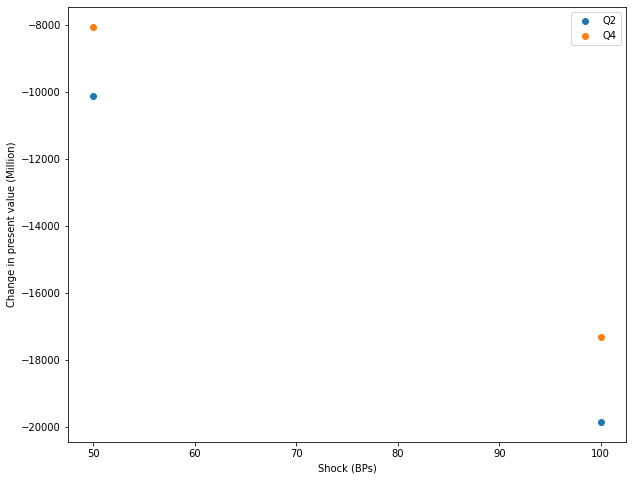

In [9]:
plt.figure(figsize=(10,8))
plt.scatter([50,100], [PV_50, PV_100],label='Q2')
plt.scatter([50,100], [PV_50_new, PV_100_new],label='Q4')
plt.xlabel('Shock (BPs)')
plt.ylabel('Change in present value (Million)')
plt.legend()
plt.show()

In Q2, we assumed that CPRs stay the same when we shocked the rates, but in Q4, CPRs also changed when we shocked the forward rates (forward rates change --> swap rates change --> mortgage rates change --> PSA change)